<a href="https://colab.research.google.com/github/ovbystrova/Interference/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !wget https://github.com/ovbystrova/Interference/raw/master/data/original_texts.csv

## Dataset

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('original_texts.csv', index_col='id')

In [4]:
df.head()

,native,language_background,title,text,date1,date2,level,annotated,checked
id,,,,,,,,,
1,eng,HL,"expository (non-timed, paragraph, Environmenta...",Загрязнение тяжелыми металлами Дальнегорского...,2009.0,2010.0,AM,1,1
2,NaN,NaN,–,Многие жители России пишут письма президенту М...,2000.0,2013.0,NaN,1,1
3,eng,HL,"business correspondence (non-timed, paragraph,...",Директору магазина « Адидас» М. И. Васильченк...,2009.0,2010.0,AM,1,1
4,eng,FL,"definition (non-timed, sentences, Russian in t...",&lt; Что такое аннотация?&gt;. Что такое анно...,2011.0,2012.0,IH,1,1
5,eng,FL,"summary (non-timed, paragraph, Capstone)","Вывод. Спасибо, ребята, за хорошие ответы. Я ...",2012.0,2013.0,AM,1,1


In [0]:
df = df.drop(['title', 'date1', 'date2', 'level', 'annotated', 'checked'], axis=1)

In [0]:
df = df.dropna()

In [7]:
df.head()

,native,language_background,text
id,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...


In [8]:
df['native'].value_counts()

eng    3145
jap    1571
fin    1231
fr      495
kaz     494
ger     283
kor     197
swe     178
ita     115
taj      30
nor      28
chi      24
ser      19
dut      18
est       2
Name: native, dtype: int64

In [9]:
df['language_background'].value_counts()

FL    5396
HL    2434
Name: language_background, dtype: int64

In [10]:
df.head()

,native,language_background,text
id,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...


## Word n-grams + truncation

### Choose word number limit for truncation

In [11]:
df['len'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,native,language_background,text,len
id,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,369
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,187
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...,30
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385
6,eng,FL,Записи. Первая проблема- что производить? втор...,278


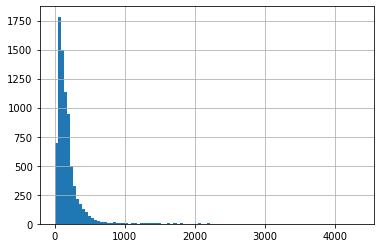

In [12]:
df['len'].hist(bins=100)

In [0]:
import numpy as np

In [0]:
from scipy import stats

In [15]:
np.mean(list(df['len']))

179.54738186462325

In [16]:
stats.mode(list(df['len']))

ModeResult(mode=array([64]), count=array([58]))

In [17]:
len(df[df['len'] >= 64])

6317

### Tokenize texts

In [0]:
import re

In [0]:
df['word_tokens'] = df['text'].apply(lambda x: re.findall('\w+', x.lower()))

In [20]:
df.head()

,native,language_background,text,len,word_tokens
id,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,369,"[загрязнение, тяжелыми, металлами, дальнегорск..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,187,"[директору, магазина, адидас, м, и, васильченк..."
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...,30,"[lt, что, такое, аннотация, gt, что, такое, ан..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в..."


### Truncate texts by words

In [0]:
df['words_truncated'] = df.word_tokens.apply(lambda x: [x[i] for i in range(len(x)) if i <= 64])

In [22]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated
id,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,369,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,187,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк..."
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...,30,"[lt, что, такое, аннотация, gt, что, такое, ан...","[lt, что, такое, аннотация, gt, что, такое, ан..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в..."


### Universal n-gram functions for the dataset

In [0]:
def collecting_ngrams(token_list, n, char=True):
  ngram_list = []
  for i in range(len(token_list)):
    ngram = token_list[i]
    if i + n > len(token_list):
      break
    else:
      for it in range(1, n):
        if char == True:
          ngram = ngram + token_list[i + it]
        else:
          ngram = ngram + ' ' + token_list[i + it]
    ngram_list.append(ngram)
  return ngram_list


In [0]:
from collections import Counter

In [0]:
def freq_ngrams(token_list, n_grams, n_freq, char=True):
  ngram_list = collecting_ngrams(token_list, n_grams, char=char)
  
  return Counter(ngram_list).most_common(n_freq)

### Making word bi- and trigrams

In [0]:
df['word_unigrams'] = df.words_truncated.apply(lambda x: Counter(x).most_common(3000))

In [0]:
df['word_bigrams'] = df.words_truncated.apply(lambda x: freq_ngrams(x, 2, 3000, char=False))

In [0]:
df['word_trigrams'] = df.words_truncated.apply(lambda x: freq_ngrams(x, 3, 3000, char=False))

In [29]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated,word_unigrams,word_bigrams,word_trigrams
id,,,,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,369,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск...","[(загрязнение, 2), (тяжелыми, 2), (металлами, ...","[(тяжелыми металлами, 2), (пос рудная, 2), (ру...","[(пос рудная пристань, 2), (загрязнение тяжелы..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,187,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк...","[(магазина, 2), (адидас, 2), (г, 2), (владимир...","[(магазина адидас, 2), (г владимир, 2), (влади...","[(г владимир ул, 2), (директору магазина адида..."
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...,30,"[lt, что, такое, аннотация, gt, что, такое, ан...","[lt, что, такое, аннотация, gt, что, такое, ан...","[(что, 2), (такое, 2), (аннотация, 2), (как, 2...","[(что такое, 2), (такое аннотация, 2), (lt что...","[(что такое аннотация, 2), (lt что такое, 1), ..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ...","[(все, 3), (и, 3), (что, 3), (во, 2), (согласн...","[(согласны что, 2), (вывод спасибо, 1), (спаси...","[(вывод спасибо ребята, 1), (спасибо ребята за..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в...","[(и, 5), (производить, 3), (первая, 2), (пробл...","[(записи первая, 1), (первая проблема, 1), (пр...","[(записи первая проблема, 1), (первая проблема..."


## Character n-grams + truncation

### Choose character number limit

In [0]:
df['len_sym'] = df.text.apply(lambda x: len(x))

In [31]:
stats.mode(list(df['len_sym']))

ModeResult(mode=array([1076]), count=array([14]))

In [32]:
len(df[df.len_sym >= 630])

5213

### Truncate texts by characters

In [0]:
df['char_truncated'] = df.text.apply(lambda x: x[:630])

### Make frequent n-gram samples, 3 <= n <= 10

In [0]:
from tqdm import tqdm

In [0]:
try:
  for instance in tqdm._instances:
    tqdm.decr_(instance)
except AttributeError:
  pass

In [36]:
for i in tqdm(range(3, 11)):
  col_name = 'character {}-grams'.format(i)
  df[col_name] = df.char_truncated.apply(lambda x: freq_ngrams(x, i, 3000, char=True))

100%|██████████| 8/8 [01:05<00:00,  9.29s/it]


In [37]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated,word_unigrams,word_bigrams,word_trigrams,len_sym,char_truncated,character 3-grams,character 4-grams,character 5-grams,character 6-grams,character 7-grams,character 8-grams,character 9-grams,character 10-grams
id,,,,,,,,,,,,,,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,369,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск...","[(загрязнение, 2), (тяжелыми, 2), (металлами, ...","[(тяжелыми металлами, 2), (пос рудная, 2), (ру...","[(пос рудная пристань, 2), (загрязнение тяжелы...",2813,Загрязнение тяжелыми металлами Дальнегорского...,"[(ых , 5), (агр, 4), (гря, 4), (ряз, 4), (язн,...","[(агря, 4), (гряз, 4), (рязн, 4), (язне, 4), (...","[(агряз, 4), (грязн, 4), (рязне, 4), (язнен, 4...","[(агрязн, 4), (грязне, 4), (рязнен, 4), (язнен...","[(агрязне, 4), (грязнен, 4), (рязнени, 3), (вл...","[(агрязнен, 4), (грязнени, 3), (вляется , 3), ...","[(агрязнени, 3), ( загрязне, 3), (загрязнен, 3...","[( загрязнен, 3), (агрязнение, 2), (грязнение ..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,187,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк...","[(магазина, 2), (адидас, 2), (г, 2), (владимир...","[(магазина адидас, 2), (г владимир, 2), (влади...","[(г владимир ул, 2), (директору магазина адида...",1391,Директору магазина « Адидас» М. И. Васильченк...,"[(го , 7), (на , 5), (ина, 4), (л. , 4), (ени,...","[(ого , 4), (ина , 3), (его , 3), (ения, 3), (...","[(ного , 3), (ать н, 3), ( Дире, 2), (Дирек, 2...","[( Дирек, 2), (Директ, 2), (иректо, 2), (ректо...","[( Директ, 2), (Директо, 2), (иректор, 2), (ре...","[( Директо, 2), (Директор, 2), (иректору, 2), ...","[( Директор, 2), (Директору, 2), (иректору , 2...","[( Директору, 2), (Директору , 2), ( магазина ..."
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...,30,"[lt, что, такое, аннотация, gt, что, такое, ан...","[lt, что, такое, аннотация, gt, что, такое, ан...","[(что, 2), (такое, 2), (аннотация, 2), (как, 2...","[(что такое, 2), (такое аннотация, 2), (lt что...","[(что такое аннотация, 2), (lt что такое, 1), ...",210,&lt; Что такое аннотация?&gt;. Что такое анно...,"[(то , 3), ( Чт, 2), (Что, 2), (о т, 2), ( та,...","[( Что, 2), (Что , 2), (то т, 2), (о та, 2), (...","[( Что , 2), (Что т, 2), (то та, 2), (о так, 2...","[( Что т, 2), (Что та, 2), (то так, 2), (о так...","[( Что та, 2), (Что так, 2), (то тако, 2), (о ...","[( Что так, 2), (Что тако, 2), (то такое, 2), ...","[( Что тако, 2), (Что такое, 2), (то такое , 2...","[( Что такое, 2), (Что такое , 2), (то такое а..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ...","[(все, 3), (и, 3), (что, 3), (во, 2), (согласн...","[(согласны что, 2), (вывод спасибо, 1), (спаси...","[(вывод спасибо ребята, 1), (спасибо ребята за...",2488,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...","[(то , 6), ( от, 5), ( по, 5), ( и , 5), (, ч,...","[(, чт, 5), ( что, 5), (ать , 4), ( все, 4), (...","[(, что, 5), ( все , 4), ( что , 4), (. Во-, 3...","[(, что , 4), (е согл, 3), ( согла, 3), (согла...","[(е согла, 3), ( соглас, 3), (согласн, 3), (ог...","[(е соглас, 3), ( согласн, 3), (согласны, 3), ...","[(е согласн, 3), ( согласны, 3), (согласны,, 3...","[(е согласны, 3), ( согласны,, 3), (согласны, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в...","[(и, 5), (производить, 3), (первая, 2), (пробл...","[(записи первая, 1), (первая проблема, 1), (пр...","[(записи первая проблема, 1), (первая проблема...",2289,Записи. Первая проблема- что производить? втор...,"[(ств, 10), ( пр, 8), (ая , 6), (про, 6), (ные...","[(ные , 6), ( про, 5), (щест, 5), (еств, 5), (...","[(ществ, 5), ( экон, 4), (ные и, 4), ( прои, 3...",

## Transform frequent n-gram lists to Counters

In [0]:
def make_counter(commons):
  return Counter({x[0]: x[1] for x in commons})

In [0]:
to_counters = ['word_unigrams', 'word_bigrams', 'word_trigrams'] + ['character {}-grams'.format(i) for i in range(3, 11)]

In [0]:
for col in to_counters:
  df[col] = df[col].apply(make_counter)

In [41]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated,word_unigrams,word_bigrams,word_trigrams,len_sym,char_truncated,character 3-grams,character 4-grams,character 5-grams,character 6-grams,character 7-grams,character 8-grams,character 9-grams,character 10-grams
id,,,,,,,,,,,,,,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,369,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск...","{'загрязнение': 2, 'тяжелыми': 2, 'металлами':...","{'тяжелыми металлами': 2, 'пос рудная': 2, 'ру...","{'пос рудная пристань': 2, 'загрязнение тяжелы...",2813,Загрязнение тяжелыми металлами Дальнегорского...,"{'ых ': 5, 'агр': 4, 'гря': 4, 'ряз': 4, 'язн'...","{'агря': 4, 'гряз': 4, 'рязн': 4, 'язне': 4, '...","{'агряз': 4, 'грязн': 4, 'рязне': 4, 'язнен': ...","{'агрязн': 4, 'грязне': 4, 'рязнен': 4, 'язнен...","{'агрязне': 4, 'грязнен': 4, 'рязнени': 3, 'вл...","{'агрязнен': 4, 'грязнени': 3, 'вляется ': 3, ...","{'агрязнени': 3, ' загрязне': 3, 'загрязнен': ...","{' загрязнен': 3, 'агрязнение': 2, 'грязнение ..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,187,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк...","{'магазина': 2, 'адидас': 2, 'г': 2, 'владимир...","{'магазина адидас': 2, 'г владимир': 2, 'влади...","{'г владимир ул': 2, 'директору магазина адида...",1391,Директору магазина « Адидас» М. И. Васильченк...,"{'го ': 7, 'на ': 5, 'ина': 4, 'л. ': 4, 'ени'...","{'ого ': 4, 'ина ': 3, 'его ': 3, 'ения': 3, '...","{'ного ': 3, 'ать н': 3, ' Дире': 2, 'Дирек': ...","{' Дирек': 2, 'Директ': 2, 'иректо': 2, 'ректо...","{' Директ': 2, 'Директо': 2, 'иректор': 2, 'ре...","{' Директо': 2, 'Директор': 2, 'иректору': 2, ...","{' Директор': 2, 'Директору': 2, 'иректору ': ...","{' Директору': 2, 'Директору ': 2, ' магазина ..."
4,eng,FL,&lt; Что такое аннотация?&gt;. Что такое анно...,30,"[lt, что, такое, аннотация, gt, что, такое, ан...","[lt, что, такое, аннотация, gt, что, такое, ан...","{'что': 2, 'такое': 2, 'аннотация': 2, 'как': ...","{'что такое': 2, 'такое аннотация': 2, 'lt что...","{'что такое аннотация': 2, 'lt что такое': 1, ...",210,&lt; Что такое аннотация?&gt;. Что такое анно...,"{'то ': 3, ' Чт': 2, 'Что': 2, 'о т': 2, ' та'...","{' Что': 2, 'Что ': 2, 'то т': 2, 'о та': 2, '...","{' Что ': 2, 'Что т': 2, 'то та': 2, 'о так': ...","{' Что т': 2, 'Что та': 2, 'то так': 2, 'о так...","{' Что та': 2, 'Что так': 2, 'то тако': 2, 'о ...","{' Что так': 2, 'Что тако': 2, 'то такое': 2, ...","{' Что тако': 2, 'Что такое': 2, 'то такое ': ...","{' Что такое': 2, 'Что такое ': 2, 'то такое а..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ...","{'все': 3, 'и': 3, 'что': 3, 'во': 2, 'согласн...","{'согласны что': 2, 'вывод спасибо': 1, 'спаси...","{'вывод спасибо ребята': 1, 'спасибо ребята за...",2488,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...","{'то ': 6, ' от': 5, ' по': 5, ' и ': 5, ', ч'...","{', чт': 5, ' что': 5, 'ать ': 4, ' все': 4, '...","{', что': 5, ' все ': 4, ' что ': 4, '. Во-': ...","{', что ': 4, 'е согл': 3, ' согла': 3, 'согла...","{'е согла': 3, ' соглас': 3, 'согласн': 3, 'ог...","{'е соглас': 3, ' согласн': 3, 'согласны': 3, ...","{'е согласн': 3, ' согласны': 3, 'согласны,': ...","{'е согласны': 3, ' согласны,': 3, 'согласны, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в...","{'и': 5, 'производить': 3, 'первая': 2, 'пробл...","{'записи первая': 1, 'первая проблема': 1, 'пр...","{'записи первая проблема': 1, 'первая проблема...",2289,Записи. Первая проблема- что производить? втор...,"{'ств': 10, ' пр': 8, 'ая ': 6, 'про': 6, 'ные...","{'ные ': 6, ' про': 5, 'щест': 5, 'еств': 5, '...","{'ществ': 5, ' экон': 4, 'ные и': 4, ' прои': ...",

## Note 
Texts of length less than 64 words / 630 characters are not removed from the dataset